# License 
***
Copyright 2017 J. Patrick Hall, phall@h2o.ai & Navdeep Gill, navdeep@h2o.ai

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Local Interpretable Model Agnostic Explanations (LIME)
***

Based on: Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin. "Why should I trust you?: Explaining the predictions of any classifier." In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 1135-1144. ACM, 2016.

http://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf

**This notebook puts forward a variant of LIME that is faster to evaluate on new data. Instead of perturbing a sample of interest to create a local region in which to fit a linear model, these examples use a practical sample, say all one story homes, from the data to create an approximately local region in which to fit a linear model. That model can be validated and visualized, and the approximately local region can be examined to explain local prediction behavior.**

Python software for the original LIME approach is available here:  https://github.com/marcotcr/lime.

## Preliminaries: imports, start h2o, load and clean data 

In [19]:
# imports
import h2o 
import operator
import numpy as np
import pandas as pd
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [20]:
# start h2o
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpuvl012_y
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpuvl012_y/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpuvl012_y/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.14.0.2
H2O cluster version age:,2 months and 11 days
H2O cluster name:,H2O_from_python_phall_655zj9
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


#### Load and prepare data for modeling

In [21]:
# load data
path = '../data/train.csv'
frame = h2o.import_file(path=path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [22]:
# assign target and inputs
y = 'SalePrice'
X = [name for name in frame.columns if name not in [y, 'Id']]

#### LIME is simpler to use with data containing no missing values

In [23]:
# determine column types
# impute
reals, enums = [], []
for key, val in frame.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        else: 
            reals.append(key)
            
_ = frame[reals].impute(method='median')
_ = frame[enums].impute(method='mode')

In [24]:
# split into training and validation
train, valid = frame.split_frame([0.7])

#### LIME can be unstable with data in which strong correlations exist between input variables

In [25]:
# print out correlated pairs
corr = train[reals].cor().as_data_frame()
for i in range(0, corr.shape[0]):
    for j in range(0, corr.shape[1]):
        if i != j:
            if np.abs(corr.iat[i, j]) > 0.7:
                print(corr.columns[i], corr.columns[j])

TotalBsmtSF 1stFlrSF
GarageYrBlt YearBuilt
GarageArea GarageCars
TotRmsAbvGrd GrLivArea
1stFlrSF TotalBsmtSF
GarageCars GarageArea
YearBuilt GarageYrBlt
GrLivArea TotRmsAbvGrd


#### Remove one var from each correlated pair

In [26]:
X_reals_decorr = [i for i in reals if i not in  ['GarageYrBlt', 'TotRmsAbvGrd', 'TotalBsmtSF', 'GarageCars']]

## Train a predictive model

In [27]:
# train GBM model
model = H2OGradientBoostingEstimator(ntrees=100,
                                     max_depth=10,
                                     distribution='huber',
                                     learn_rate=0.1,
                                     stopping_rounds=5,
                                     seed=12345)

model.train(y=y, x=X_reals_decorr, training_frame=train, validation_frame=valid)

preds = valid['Id'].cbind(model.predict(valid))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


## Build local linear surrogate models to help interpret the model

#### Create a local region based on HouseStyle

In [28]:
local_frame = preds.cbind(valid.drop(['Id']))
local_frame = local_frame[local_frame['HouseStyle'] == '1Story']
local_frame['predict'] = local_frame['predict'].log()
local_frame.describe()

Rows:198
Cols:82




,Id,predict,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
type,int,real,int,enum,real,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,int,int,int,enum,enum,enum,enum,enum,real,enum,enum,enum,enum,enum,enum,enum,int,enum,int,int,int,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,enum,int,enum,int,enum,enum,real,enum,int,int,enum,enum,enum,int,int,int,int,int,int,enum,enum,enum,int,int,int,enum,enum,int
mins,2.0,11.070745828225096,20.0,,30.0,3013.0,,,,,,,,,,,,,3.0,2.0,1910.0,1950.0,,,,,,0.0,,,,,,,,0.0,,0.0,0.0,0.0,,,,,672.0,0.0,0.0,672.0,0.0,0.0,1.0,0.0,1.0,1.0,,3.0,,0.0,,,1926.0,,0.0,0.0,,,,0.0,0.0,0.0,0.0,0.0,0.0,,,,0.0,1.0,2006.0,,,34900.0
mean,729.4343434343434,12.017811662448375,38.18181818181818,,70.64873127612512,10409.732323232323,,,,,,,,,,,,,6.095959595959596,5.338383838383838,1978.3636363636363,1986.7373737373737,,,,,,89.04227537078778,,,,,,,,527.469696969697,,58.06060606060606,630.6919191919192,1216.2222222222222,,,,,1313.1919191919192,2.3585858585858595,0.0,1315.5505050505053,0.47474747474747475,0.05555555555555555,1.5,0.11616161616161616,2.6313131313131315,1.0454545454545454,,5.898989898989899,,0.51010101010101,,,1983.321174031834,,1.8131313131313131,482.8939393939394,,,,92.8989898989899,43.24242424242424,16.51010101010101,5.277777777777778,11.055555555555555,0.0,,,,10.353535353535353,6.651515151515151,2007.7525252525252,,,178296.5606060606
maxs,1455.0,12.908772296495144,190.0,,153.0,115149.0,,,,,,,,,,,,,10.0,9.0,2010.0,2010.0,,,,,,922.0,,,,,,,,1721.0,,1080.0,2336.0,2392.0,,,,,2392.0,467.0,0.0,2392.0,1.0,1.0,3.0,1.0,6.0,2.0,,10.0,,3.0,,,2010.0,,4.0,1134.0,,,,476.0,523.0,286.0,407.0,266.0,0.0,,,,600.0,12.0,2010.0,,,465000.0
sigma,424.59698805610725,0.3608417166047056,38.83751486828733,,18.725067162882702,8692.203883325865,,,,,,,,,,,,,1.4270354910707268,0.988071707739855,25.61624426933196,20.87725104849402,,,,,,132.25509806522794,,,,,,,,450.1282125200626,,198.89084924229465,513.6801934595525,441.7615535145228,,,,,366.91528439711635,33.18824484602336,0.0,367.3551857013489,0.5006277144706721,0.22964206189926228,0.511293770543857,0.3212308405733264,0.7609967368069026,0.20882690341134452,,1.3059407367944684,,0.6107322640688054,,,21.13931240434903,,0.8000185866681541,221.48722932702188,,,,108.81344300997546,67.43368103741375,53.694732171172134,39.33829086312196,43.142332543616654,0.0,,,,72.70255277726656,2.7804197045179717,1.3497014849009412,,,74097.36557490406
zeros,0,0,0,,0,0,,,,,,,,,,,,,0,0,0,0,,,,,,101,,,,,,,,46,,176,17,8,,,,,0,197,198,0,104,187,0,175,0,0,,0,,108,,,0,,15,15,,,,97,88,178,194,185,198,,,,194,0,0,,,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,2.0,12.063667847671415,20.0,RL,80.0,9600.0,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,NA,NA,NA,0.0,5.0,2007.0,WD,Normal,181500.0
1,20.0,11.818487

#### Train penalized linear model in local region 
* Check R<sup>2</sup> to ensure surrogate model is a good fit for predictions
* Use ranked predictions plot to ensure surrogate model is a good fit for predictions
* Use trained GLM and coefficients to understand local region of response function

The original LIME approach also recommends discretizing numeric inputs to increase local surrogate model accuracy. With such high R<sup>2</sup>, this intermediate step would likely not increase explanation quality for this local model.

In [29]:
%matplotlib inline

In [30]:
# initialize
local_glm = H2OGeneralizedLinearEstimator(lambda_search=True)

# train 
local_glm.train(x=X_reals_decorr, y='predict', training_frame=local_frame)

# coefs
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))
        
# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm.r2())

glm Model Build progress: |███████████████████████████████████████████████| 100%

Local GLM Coefficients:
KitchenAbvGr:             -0.05549218944269473
BsmtHalfBath:             -0.01602553934505203
YrSold:                   -0.0038175754324416395
MSSubClass:               -0.000272250653872369
OpenPorchSF:              1.2612497964484666e-06
LotArea:                  1.5094884910832366e-06
EnclosedPorch:            8.55933001243271e-06
3SsnPorch:                3.829931682454385e-05
BsmtFinSF2:               4.6266206999188305e-05
MasVnrArea:               8.527191564522695e-05
BsmtFinSF1:               9.30044436554525e-05
GrLivArea:                0.00011804004708297016
WoodDeckSF:               0.00012750978240763422
GarageArea:               0.00014104291308379176
1stFlrSF:                 0.00020229964875565968
LotFrontage:              0.00020720225957226396
BsmtFullBath:             0.00041100357548717393
YearRemodAdd:             0.001059257630293266
YearBuilt:               

glm prediction progress: |████████████████████████████████████████████████| 100%


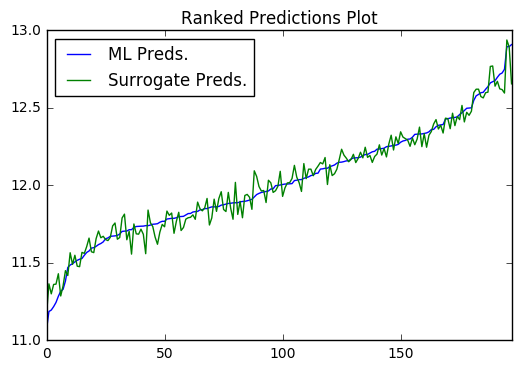

In [31]:
# ranked predictions plot
pred_frame = local_frame.cbind(local_glm.predict(local_frame))\
                        .as_data_frame()[['predict', 'predict0']]
pred_frame.columns = ['ML Preds.', 'Surrogate Preds.']
pred_frame.sort_values(by='ML Preds.', inplace=True)
pred_frame.reset_index(inplace=True, drop=True)
_ = pred_frame.plot(title='Ranked Predictions Plot')

A ranked predictions plot is a way to visually check whether the surrogate model is a good fit for the complex model. The y-axis is the numeric prediction of both models for a given point. The x-axis is the rank of a point when the predictions are sorted by their GBM prediction, from lowest on the left to highest on the right. When both sets of predictions are aligned, as they are above, this a good indication that the linear model fits the complex, nonlinear GBM well in the approximately local region.

Both the R<sup>2</sup> and ranked predictions plot show the linear model is a good fit in the practical, approximately local sample. This means the regression coefficients are likely a very accurate representation of the behavior of the nonlinear model in this region.

#### Create explanations (or 'reason codes') for a row in the local set
The local glm coefficient multiplied by the value in a specific row are estimates of how much each variable contributed to each prediction decision. These values can tell you how a variable and it's values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are often to referred to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders must provide reasons for turning down a credit application for automated decisions. Reason codes can be easily extracted from LIME local feature importance values, by simply ranking the variables that played the largest role in any given decision.

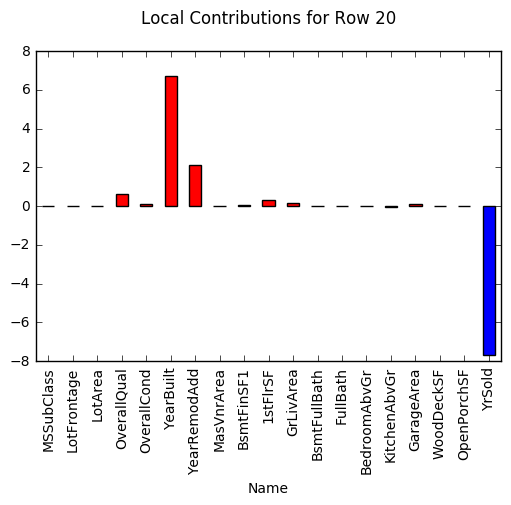

In [32]:
row = 20 # select a row to describe
local_contrib_frame = pd.DataFrame(columns=['Name', 'Local Contribution', 'Sign'])

# multiply values in row by local glm coefficients
for name in local_frame[row, :].columns:
    contrib = 0.0
    try:
        contrib = local_frame[row, name]*local_glm.coef()[name]
    except:
        pass
    if contrib != 0.0:
        local_contrib_frame = local_contrib_frame.append({'Name':name,
                                                          'Local Contribution': contrib,
                                                          'Sign': contrib > 0}, 
                                                         ignore_index=True)

# plot
_ = local_contrib_frame.plot(x = 'Name',
                             y = 'Local Contribution',
                             kind='bar', 
                             title='Local Contributions for Row ' + str(row) + '\n', 
                             color=''.join(local_contrib_frame.Sign.map({True: 'r', False: 'b'})), 
                             legend=False)     

#### Create a local region based on predicted SalePrice quantiles

In [33]:
local_frame = preds.cbind(valid.drop(['Id'])).as_data_frame()
local_frame.sort_values('predict', axis=0, inplace=True)
local_frame = local_frame.iloc[0: local_frame.shape[0]//10, :]
local_frame = h2o.H2OFrame(local_frame)
local_frame['predict'] = local_frame['predict'].log()
local_frame.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:41
Cols:82




,Id,predict,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
type,int,real,int,enum,real,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,int,int,int,enum,enum,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,enum,int,enum,int,int,int,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,enum,int,enum,int,enum,enum,real,enum,int,int,enum,enum,enum,int,int,int,int,int,int,enum,enum,enum,int,int,int,enum,enum,int
mins,89.0,11.070745828225096,20.0,,21.0,1680.0,,,,,,,,,,,,,3.0,2.0,1875.0,1950.0,,,,,,0.0,,,,,,,,0.0,,0.0,0.0,0.0,,,,,483.0,0.0,0.0,672.0,0.0,0.0,1.0,0.0,2.0,1.0,,4.0,,0.0,,,1916.0,,0.0,0.0,,,,0.0,0.0,0.0,0.0,0.0,0.0,,,,0.0,1.0,2006.0,,,34900.0
mean,803.6829268292681,11.42984875449125,57.31707317073171,,58.367072155317736,6990.512195121953,,,,,,,,,,,,,4.609756097560976,5.097560975609754,1937.5365853658532,1964.3170731707316,,,,,,40.90243902439023,,,,,,,,103.46341463414633,,9.21951219512195,578.7317073170733,691.4146341463413,,,,,793.3902439024392,207.46341463414637,12.512195121951219,1013.3658536585366,0.07317073170731707,0.024390243902439025,1.0731707317073171,0.17073170731707318,2.4146341463414642,1.024390243902439,,5.2195121951219505,,0.04878048780487805,,,1964.575125134863,,1.024390243902439,245.39024390243907,,,,29.999999999999993,36.97560975609756,62.024390243902445,0.0,4.097560975609756,0.0,,,,0.0,6.634146341463415,2007.9756097560978,,,93270.73170731707
maxs,1409.0,11.598697596478692,160.0,,153.0,19138.0,,,,,,,,,,,,,6.0,9.0,1973.0,2008.0,,,,,,604.0,,,,,,,,544.0,,273.0,1095.0,1095.0,,,,,1126.0,720.0,513.0,1774.0,1.0,1.0,2.0,1.0,5.0,2.0,,8.0,,1.0,,,2002.0,,4.0,779.0,,,,328.0,523.0,286.0,0.0,168.0,0.0,,,,0.0,12.0,2010.0,,,141000.0
sigma,428.8641649184734,0.1336092801126828,49.28358703685753,,27.694167741609235,3520.7560915373783,,,,,,,,,,,,,0.9186416270909946,1.6401962999711424,23.897800694808353,19.091148504464396,,,,,,122.00815646464969,,,,,,,,160.53334506590454,,45.29597785406666,311.91521479323865,256.313087415543,,,,,171.53904483364428,268.7950053071091,80.11713984885492,235.7143139583976,0.2636516548818748,0.15617376188860607,0.2636516548818748,0.3809487514345101,0.7407971974871922,0.15617376188860604,,1.1294289513278652,,0.21808478995509087,,,21.08021154632724,,0.9614521537249989,206.0955940878868,,,,78.24193249147159,91.08690570133504,84.81405773952748,0.0,26.23719199728582,0.0,,,,0.0,2.6149196695211847,1.2745156899396746,,,20467.03744930417
zeros,0,0,0,,0,0,,,,,,,,,,,,,0,0,0,0,,,,,,35,,,,,,,,27,,39,5,3,,,,,0,24,40,0,38,40,0,34,0,0,,0,,39,,,0,,13,13,,,,34,26,24,41,40,41,,,,41,0,0,,,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1381.0,11.070745828225096,30.0,RL,45.0,8212.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,3.0,3.0,1914.0,1950.0,Gable,CompShg,Stucco,Stucco,None,0.0,TA,Fa,BrkTil,TA,Fa,No,Rec,203.0,Unf,0.0,661.0,864.0,GasA,TA,N,FuseF,864.0,0.0,0.0,864.0,1.0,0.0,1.0,0.0,2.0,1.0,TA,5.0,Typ,0.0,nan,Detchd,1938.0,Unf,1.0,200.0,TA,Fa,Y,0.0,0.0,96.0,0.0,0.0,0.0,nan,nan,nan,0.0,6.0,2010.0,WD,Normal,58500.0
1,156.0,11.183282815681657,50.0,RL,60.0,96

#### Train penalized linear model in local region 

glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%

Local GLM R-square:
0.85

Local GLM Coefficients:
KitchenAbvGr:             -0.17838102939061104
BsmtHalfBath:             -0.05022074033103475
BsmtFullBath:             -0.023083417240573025
YrSold:                   -0.0028808710400660383
MoSold:                   -0.0011127886509068401
MasVnrArea:               -2.6479521563793614e-05
LotArea:                  4.418702336771515e-06
EnclosedPorch:            5.668542232946618e-05
BsmtUnfSF:                0.00013717826794159898
GrLivArea:                0.0001404552584131384
WoodDeckSF:               0.00016940843967922121
1stFlrSF:                 0.00018096078865231032
BsmtFinSF1:               0.00021908801185125906
OpenPorchSF:              0.00027137451293274473
GarageArea:               0.0003448156614722901
BsmtFinSF2:               0.00036657786043385945
ScreenPorch

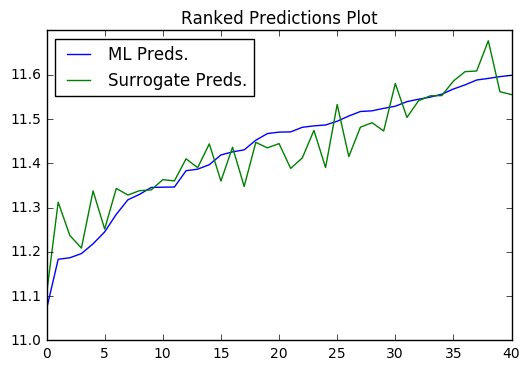

In [34]:
# initialize
local_glm = H2OGeneralizedLinearEstimator(lambda_search=True)

# train 
local_glm.train(x=X_reals_decorr, y='predict', training_frame=local_frame)

# ranked predictions plot
pred_frame = local_frame.cbind(local_glm.predict(local_frame))\
                        .as_data_frame()[['predict', 'predict0']]
pred_frame.columns = ['ML Preds.', 'Surrogate Preds.']
pred_frame.sort_values(by='ML Preds.', inplace=True)
pred_frame.reset_index(inplace=True, drop=True)
_ = pred_frame.plot(title='Ranked Predictions Plot')

# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm.r2())

# coefs
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))

Here the R<sup>2</sup> and ranked predictions plot show a slightly less accurate fit in the local sample. So the regression coefficients and reason codes may be a bit more approximate than those in the first example.

#### Create explanations (or 'reason codes') for a row in the local set

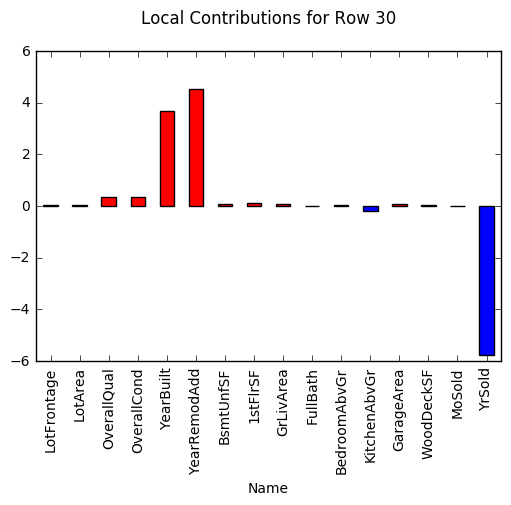

In [35]:
row = 30 # select a row to describe
local_contrib_frame = pd.DataFrame(columns=['Name', 'Local Contribution', 'Sign'])

# multiply values in row by local glm coefficients
for name in local_frame[row, :].columns:
    contrib = 0.0
    try:
        contrib = local_frame[row, name]*local_glm.coef()[name]
    except:
        pass
    if contrib != 0.0:
        local_contrib_frame = local_contrib_frame.append({'Name':name,
                                                          'Local Contribution': contrib,
                                                          'Sign': contrib > 0}, 
                                                         ignore_index=True)
# plot            
_ = local_contrib_frame.plot(x = 'Name',
                             y = 'Local Contribution',
                             kind='bar', 
                             title='Local Contributions for Row ' + str(row) + '\n', 
                             color=''.join(local_contrib_frame.Sign.map({True: 'r', False: 'b'})),
                             legend=False)

#### Shutdown H2O

In [36]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_8e69 closed.
